In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import pathlib
import random
import pandas as pd
import sys

from credentials import CONNECTION_INFO
from constants import *
from crackers import Caesar_Cracker

import encoders
import db_connect
import helpers
import tf_helpers

# Callbacks for use with TensorFlow
from tf_helpers import modulo_output, modulo_distance_loss, modulo_distance_accuracy, modulo_rounded_accuracy, initialize_save_best

2024-12-01 21:28:21.853505: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 21:28:21.887136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 21:28:21.914183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 21:28:21.921819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 21:28:21.967991: I tensorflow/core/platform/cpu_feature_guar

## Config
This notebook has a lot of options to adjust, most of which are controlled here.

In [2]:
ENCODER = encoders.ENCODER_CAESAR
CHUNK_SIZE = 256
PROCESSING_UNITS = CHUNK_SIZE

EXTRA_CHECKS = False # Whether to run some (potentially slow) debug checks

INFER_TEXT = False # Text inferrence isn't really working. I don't know how to combine the time-distributed results.
INFER_KEY = not INFER_TEXT

if INFER_TEXT:
    MAIN_ACCURACY_METRIC = "mae"
    LOSS_METRIC = "mean_squared_error"
    OUTPUT_SIZE = CHUNK_SIZE
    OPTIMIZER = "sgd"
else:
    MAIN_ACCURACY_METRIC = "mae"
    LOSS_METRIC = "mae"
    OPTIMIZER = "adamax"    

    if ENCODER == encoders.ENCODER_CAESAR:
        OUTPUT_SIZE = 1
    elif ENCODER == encoders.ENCODER_SUBST:
        OUTPUT_SIZE = len(encoders.CHARSET)
    else:
        raise Exception(f"Unsupported encoder {ENCODER}")

ENCRYPTED_FILE_LIMIT = -1 # -1 to disable limit

BASE_TRAIN_PCT = 0.75   # Start here. If train or test count would exceed the max, reduce it. Note 0.75 is the default.
MAX_TRAIN_COUNT = -1 # -1 to disable; some setups start running out of memory around 100K
MAX_TEST_COUNT =  -1 # -1 to disable
SPLIT_SEED = 42

LOAD_BEST_MODEL = False # If False, a new model will be created from scratch
SAVE_BEST_MODEL = True
BEST_PATH = './saved_models/best.keras'

LOAD_SCALER = True # If true, load from disk. If False, calculate and save to disk.
SCALER_PATH = helpers.get_recommended_scaler_path(ENCODER, CHUNK_SIZE)

# Whether to run the tuner or the hard-coded network build code
TUNE_NETWORK = False
TUNE_QUICKLY = False # Set True to sanity check the model builder
BUILD_NETWORK = not TUNE_NETWORK
TRAIN_MODEL = BUILD_NETWORK and not LOAD_BEST_MODEL

TUNER_DIRECTORY = "tuner_projects"
TUNER_PROJECT_NAME = "KT"

EPOCHS = 10
BATCH_SIZE = int(max(32, round(256 * (512/CHUNK_SIZE)))) # Default is 32 -- going higher speeds things up a LOT, but may cause memory problems

CHUNK_SIZE, PROCESSING_UNITS, BATCH_SIZE, OUTPUT_SIZE

(256, 64, 512, 1)

# Data Retrieval and Structuring

In [3]:
db = db_connect.DB(CONNECTION_INFO)

with db.get_session() as session:
    # Get database IDs for encoders and key types
    (encoder_ids, key_type_id) = db.get_id_maps(session)

    # Map source ID to plaintext file (1) details, and source ID to corresponding ciphertext files (1+) details
    (sid_to_p, sid_to_c) = db.get_source_maps(session, ENCRYPTED_FILE_LIMIT, encoder_ids[ENCODER], test_only=False)

    # Get the features (X, the cipher texts as offsets) and targets (y, either the plain texts as offsets OR the key).
    (X, y_keys, y_texts) = db.get_features_and_targets(session, sid_to_p, sid_to_c, ENCODER, CHUNK_SIZE, want_keys=INFER_KEY, want_texts=INFER_TEXT)

X = np.array(X)
if INFER_KEY:
    y = np.array(y_keys)
if INFER_TEXT:
    y = np.array(y_texts)
        
len(sid_to_p), len(sid_to_c), X.shape, y.shape, sys.getsizeof(X), sys.getsizeof(y)

(50, 50, (535650, 256), (535650,), 1097011328, 4285312)

In [4]:
# Debugging...

all_plaintexts = ""
all_ciphertexts = ""
if EXTRA_CHECKS:
    # Get ALL the texts in one big string, for debugging
    for sid in sid_to_p:
        all_plaintexts += helpers.read_text_file(sid_to_p[sid].path)
        for c in sid_to_c[sid]:
            all_ciphertexts += helpers.read_text_file(c.path)
    
    # Make sure specified text occurs somewhere in the texts.
    # These raise exceptions if not found.
    def check_in_plaintext(to_check: str):
        if to_check not in all_plaintexts:
            raise Exception(f"Plaintext not found: {to_check}")
    
    def check_in_ciphertext(to_check: str):
        if to_check not in all_ciphertexts:
            raise Exception(f"Ciphertext not found: {to_check}")
    

    checks = round( len(X) * 0.01)
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X)-1)
        check_in_plaintext(encoders.offsets_to_string(y_texts[i].astype(int)))
        check_in_ciphertext(encoders.offsets_to_string(X[i].astype(int)))

len(all_plaintexts), len(all_ciphertexts)

(0, 0)

In [5]:
# Split the preprocessed data into a training and testing dataset
# Note we have excluded "test_only" files above, they will be used for later validation.

train_count = int(round(len(y) * BASE_TRAIN_PCT))
if train_count > MAX_TRAIN_COUNT and MAX_TRAIN_COUNT > -1:
    print(f"Train count would be {train_count}")
    train_count = int(MAX_TRAIN_COUNT)
print(f"Train count is {train_count}")

test_count = len(y) - train_count
if test_count > MAX_TEST_COUNT and MAX_TEST_COUNT > -1:
    print(f"Test count would be {test_count}")
    test_count = int(MAX_TEST_COUNT)
print(f"Test count is {test_count}")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_count, test_size=test_count, random_state=SPLIT_SEED)

if EXTRA_CHECKS:
    checks = max(10, round( min(len(X_train), len(X_test)) * 0.01))
    print(f"Checking {checks} strings")
    for _ in range(checks):
        i = random.randint(0, len(X_train)-1)
        check_in_ciphertext(encoders.offsets_to_string(X_train[i].astype(int)))

        i = random.randint(0, len(X_test)-1)
        check_in_ciphertext(encoders.offsets_to_string(X_test[i].astype(int)))

# The pre-split data sets are no longer needed, and take up a lot of memory, so get rid of them
if not EXTRA_CHECKS:
    del X
    del y
    del y_keys
    del y_texts

Train count is 401738
Test count is 133912


In [6]:
# Create a StandardScaler instances

if LOAD_SCALER:
    print(f"Loading scaler from {SCALER_PATH}")
    X_scaler = helpers.load_scaler_from_file(SCALER_PATH)
else:
    # Fit the StandardScaler
    scaler = StandardScaler()
    print("Fitting scaler")
    X_scaler = scaler.fit(X_train)

    print(f"Saving scaler to {SCALER_PATH}")
    helpers.save_scaler_to_file(X_scaler, SCALER_PATH)
    
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)   
    
to_show = min(16, CHUNK_SIZE)
X_train_scaled.shape, X_test_scaled.shape, X_train_scaled[0][0:to_show], X_test_scaled[0][0:to_show]

Loading scaler from ./saved_models/scaler_Caesar_Cipher_000256.json


((401738, 256),
 (133912, 256),
 array([ 0.47696244, -0.2108074 , -0.38305642, -0.72484768,  0.24997191,
         0.19208585,  0.08000245,  0.24804986, -0.61272532, -0.43993783,
         0.19347134,  0.53561093,  0.36756697, -1.07240843, -0.72404978,
        -0.21014106]),
 array([-0.55514241, -0.95714604, -1.18698783, -1.29906363, -1.18433153,
        -1.52807995, -0.60780222, -1.12984069, -1.53077882, -1.07113234,
        -0.60955782, -0.78376302, -1.23998657, -1.53189791, -0.78137369,
        -0.03791958]))

In [7]:
# Reshape the data as required for the model

print(f"Original shapes: {X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

X_train = tf_helpers.reshape_input(X_train, CHUNK_SIZE)
X_train_scaled = tf_helpers.reshape_input(X_train_scaled, CHUNK_SIZE)
X_test = tf_helpers.reshape_input(X_test, CHUNK_SIZE)
X_test_scaled = tf_helpers.reshape_input(X_test_scaled, CHUNK_SIZE)
y_train = tf_helpers.reshape_output(y_train, OUTPUT_SIZE)
y_test = tf_helpers.reshape_output(y_test, OUTPUT_SIZE)

print(f"Final    shapes: {X_train.shape}, {X_train_scaled.shape}, {X_test.shape}, {X_test_scaled.shape}, {y_train.shape}, {y_test.shape}")

Original shapes: (401738, 256), (133912, 256), (401738,), (133912,)
Final    shapes: (401738, 256, 1), (401738, 256, 1), (133912, 256, 1), (133912, 256, 1), (401738, 1, 1), (133912, 1, 1)


# Hyperband Tuning

In [8]:
import model_tuner

MAX_EPOCHS_PER_MODEL = 20 # Meant to get a decent idea of parameter, not create a final model. Behaves oddly below 3.
HYPERBAND_ITERATIONS = 1  # "Number of times to iterate over the full Hyperband algorithm"
EXECUTIONS_PER_TRIAL = 1  # Training from scratch
SEARCH_FIT_EPOCHS = 20    # Epochs for each attempt to do a fit, I think. Not sure how this relates to MAX_EPOCHS_PER_MODEL.
OVERWRITE = True          # I'm hoping to be able to interrupt a run and resume it later

input_shape = (None, 1, CHUNK_SIZE)
mr_t = model_tuner.ModelTuner(input_shape, OUTPUT_SIZE, CHUNK_SIZE, BATCH_SIZE)

# All-encompassing optimization parameter choices. Do not try to use all of them at once...
mr_t.CHOICES_PROCESSING_UNITS = [1, CHUNK_SIZE // 16, CHUNK_SIZE // 4, CHUNK_SIZE, CHUNK_SIZE * 2]
mr_t.CHOICES_ACTIVATIONS = ["elu", "gelu", "hard_sigmoid", "hard_silu", "hard_swish", "leaky_relu", "linear", "log_softmax", "mish",
        "relu", "relu6", "selu", "sigmoid", "silu", "softmax", "softplus", "softsign", "swish", "tanh"]
mr_t.CHOICES_FANCY_TOPO = ["GRU", "RNN", "LSTM", "GRU-RNN", "GRU-LSTM", "GRU-RNN-LSTM"]
mr_t.CHOICES_USE_OUTPUT_LIMITER = [True, False] # Prefers True
mr_t.CHOICES_OPTIMIZER = ["adamax", "sgd", "RMSProp", "adam", "Ftrl", "Lion", "Lamb"]

# Narrow down the choices as needed.
mr_t.CHOICES_PROCESSING_UNITS = [CHUNK_SIZE // 4]
mr_t.CHOICES_FANCY_TOPO = ["LSTM"]
mr_t.PICK_FANCY_TOPO_ACTIVATIONS = False

if TUNE_QUICKLY:
    MAX_EPOCHS_PER_MODEL = 3
    HYPERBAND_ITERATIONS = 1
    EXECUTIONS_PER_TRIAL = 1
    SEARCH_FIT_EPOCHS = 4

# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    return mr_t.CreateModel(hp)

# Run the kerastuner search for best hyperparameters
if TUNE_NETWORK:
    if USE_CUSTOM_METRICS:
        objective = kt.Objective("val_modulo_distance_accuracy", direction="max")
    else:
        objective = kt.Objective(f"val_{MAIN_ACCURACY_METRIC}", direction="max")

    tuner = kt.Hyperband(
        create_model,
        objective=objective,
        max_epochs=MAX_EPOCHS_PER_MODEL,
        hyperband_iterations=HYPERBAND_ITERATIONS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        overwrite=OVERWRITE,
        directory=TUNER_DIRECTORY,
        project_name=TUNER_PROJECT_NAME)
    tuner.search(X_train_scaled, y_train, epochs=SEARCH_FIT_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test_scaled, y_test))
    
    best_hyper = tuner.get_best_hyperparameters(1)[0]
    print(f"Best Hyper Values: {best_hyper.values}")
    
    nn = tuner.get_best_models(1)[0]
    eval_results = nn.evaluate(X_test_scaled, y_test, verbose=2, batch_size=BATCH_SIZE )
    print(f"Best Model Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")

    nn.save("./saved_models/tuned.keras")

# Model Reload /Creation

In [9]:
if BUILD_NETWORK:
    print("Building new model")
    nn = tf.keras.models.Sequential()

    input_shape = (None, 1, CHUNK_SIZE)
    nn.add(tf.keras.Input(shape=input_shape[1:], name="Input_Layer"))

    activation_A = "tanh"
    recurrent_activation_A = "sigmoid"
    nn.add(tf.keras.layers.LSTM(
        PROCESSING_UNITS, return_sequences=True, activation=activation_A, recurrent_activation=recurrent_activation_A,
        name=f"A_LSTM_{activation_A}_{recurrent_activation_A}"))

    nn.add(tf.keras.layers.Dense(units = OUTPUT_SIZE, activation=modulo_output, name='Modulo_Layer'))

# Check the structure of the model
print(f"Input shape: {nn.input_shape}, Output shape: {nn.output_shape}")
print(nn.summary())

Building new model


I0000 00:00:1733117347.149234  107185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733117347.302933  107185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733117347.302992  107185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733117347.309464  107185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733117347.309580  107185 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Input shape: (None, 1, 256), Output shape: (None, 1, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,241 (321.25 KB)

 Trainable params: 82,241 (321.25 KB)

 Non-trainable params: 0 (0.00 B)

None


# Model Training

In [10]:
# Reset the "best" score and set up a callback to save the model as it improves during training.
# If you're manually training iteratively, comment this out to preserve the best-ness:
model_checkpoint_callback = initialize_save_best(BEST_PATH)

# It can be helpful to load the best, train some more, and try to improve it:
if LOAD_BEST_MODEL:
    if os.path.exists(BEST_PATH):
        print(f"Loading model from {BEST_PATH}")
        nn = tf.keras.models.load_model(BEST_PATH,
            custom_objects={
                'modulo_distance_loss': modulo_distance_loss,
                'modulo_distance_accuracy': modulo_distance_accuracy,
                'modulo_rounded_accuracy': modulo_rounded_accuracy,
                'modulo_output': modulo_output
        })

# Train the model
if TRAIN_MODEL:
    # Decide what metrics to use
    if USE_CUSTOM_METRICS:
        loss = modulo_distance_loss
        metrics = [modulo_distance_accuracy, modulo_rounded_accuracy]
    else:
        loss = LOSS_METRIC
        metrics = [MAIN_ACCURACY_METRIC]

    print(nn.summary())
    print(f"Training model")
    
    if SAVE_BEST_MODEL:
        callbacks = [model_checkpoint_callback]
    else:
        callbacks = None
    
    # Compile the Sequential model together and customize metrics
    nn.compile(loss=loss, optimizer=OPTIMIZER, metrics=metrics)
    
    # Fit the model to the training data
    fit_model = nn.fit(X_train_scaled, y_train, epochs=EPOCHS, callbacks=callbacks, batch_size=BATCH_SIZE)

print(f"Input shape: {nn.input_shape}, Output shape: {nn.output_shape}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A_LSTM_tanh_sigmoid (LSTM)      │ (None, 1, 64)          │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Modulo_Layer (Dense)            │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,241 (321.25 KB)

 Trainable params: 82,241 (321.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Training model
Epoch 1/10


2024-12-01 21:29:10.691097: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


783/785 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.6739 - modulo_distance_accuracy: 0.6234 - modulo_rounded_accuracy: 0.0230
Epoch 1: modulo_distance_accuracy improved from -inf to 0.69637, saving model to ./saved_models/best.keras
785/785 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 11.6652 - modulo_distance_accuracy: 0.6237 - modulo_rounded_accuracy: 0.0231
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.9638 - modulo_distance_accuracy: 0.7431 - modulo_rounded_accuracy: 0.0434
Epoch 2: modulo_distance_accuracy improved from 0.69637 to 0.74348, saving model to ./saved_models/best.keras
785/785 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 7.9637 - modulo_distance_accuracy: 0.7431 - modulo_rounded_accuracy: 0.0434
Epoch 3/10
783/785 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.9099 - modulo_distance_accuracy: 0.7448 - modulo_rounded_accuracy: 0.0541
Epoch 3: modulo_distance_accuracy improved from 0.74348 to 0.74574, saving model to ./saved_models/best.keras
785/785 ━━━━━━━━━

# Model Evaluation

In [11]:
# Select some data for testing below...

# Predicting the whole test set can take a lot of memory, so this can be used to limit it:
TEST_SET_SIZE = X_test_scaled.shape[0]
MAX_TEST_SUBSET = 1000
TEST_SUBSET_SIZE = min(TEST_SET_SIZE, MAX_TEST_SUBSET) if MAX_TEST_SUBSET > 0 else TEST_SET_SIZE
X_test_scaled_subset = X_test_scaled[0:TEST_SUBSET_SIZE, :, :]
y_test_subset = y_test[0:TEST_SUBSET_SIZE, :, :]

# Sometimes for troubleshooting I want to use the training set, which should produce more accurate predictions:
TRAIN_SET_SIZE = X_train_scaled.shape[0]
MAX_TRAIN_SUBSET = MAX_TEST_SUBSET
TRAIN_SUBSET_SIZE = min(TRAIN_SET_SIZE, MAX_TRAIN_SUBSET) if MAX_TRAIN_SUBSET > 0 else TRAIN_SET_SIZE
X_train_scaled_subset = X_train_scaled[0:TRAIN_SUBSET_SIZE, :, :]
y_train_subset = y_train[0:TRAIN_SUBSET_SIZE, :, :]

use_training_data = False
if use_training_data:
    print("Using training data as input; results are not valid for accuracy but may be informative about function")
    input = X_train_scaled_subset
    expected = y_train_subset
else:
    print("Using test data as input")
    input = X_test_scaled_subset
    expected = y_test_subset

input.shape, expected.shape

Using test data as input


((1000, 256, 1), (1000, 1, 1))

In [12]:
print("Evaluating test set with model.evaluate() ...")
eval_results = nn.evaluate(X_test_scaled_subset, y_test_subset, batch_size=BATCH_SIZE)
print(f"Test Set        : Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")

print("Evaluating training set with model.evaluate() ...")
eval_results = nn.evaluate(X_train_scaled_subset, y_train_subset, batch_size=BATCH_SIZE)
print(f"Training Set    : Loss: {eval_results[0]}, Accuracy: {eval_results[1:]}")    

Evaluating test set with model.evaluate() ...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.1875 - modulo_distance_accuracy: 0.9295 - modulo_rounded_accuracy: 0.2233 
Test Set        : Loss: 2.168855905532837, Accuracy: [0.9300812482833862, 0.22495582699775696]
Evaluating training set with model.evaluate() ...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1131 - modulo_distance_accuracy: 0.9318 - modulo_rounded_accuracy: 0.2354
Training Set    : Loss: 2.1192374229431152, Accuracy: [0.9316228032112122, 0.23424041271209717]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
             Loss  Accuracy (Distance)  Accuracy (Rounded)
count  256.000000           256.000000          256.000000
mean     1.965754             0.936589            0.218359
std      2.266257             0.073105            0.146645
min      0.603318             0.464277            0.000000
25%      0.993843             0.943358            0.100000
50%      1.446268             0.953346            0.200000
75%      1.755915             0.967941            0.300000
max     16.607426             0.980538            0.600000


<Axes: xlabel='Offset'>

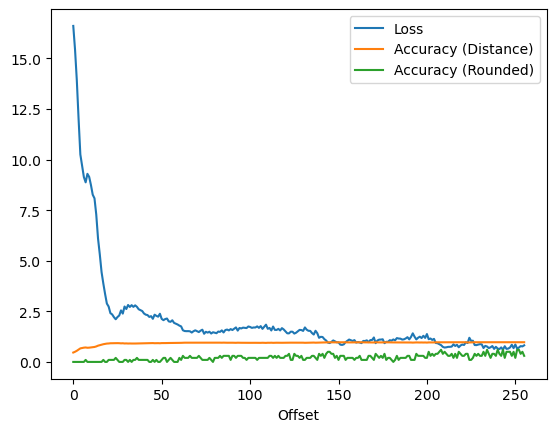

In [13]:
# This code was used to determine where to find the single best result from
# the prediction. It will be moved to the analsis notebook...

col_offset = []
col_loss = []
col_acc_dist = []
col_acc_round = []

# Looping through individual inputs is horribly slow, but I specifically wanted this
# so I could relate behaviors to what I could actually see.
HOW_MANY = 10
for _ in range(HOW_MANY):
    which_input = random.randint(0, input.shape[0]-1)
    this_input = input[which_input:which_input+1, :, :]
    this_expected = expected[which_input:which_input+1, :, :]

    raw_predicted = nn.predict(this_input, batch_size=BATCH_SIZE)
    this_predicted = raw_predicted.astype(np.float64)

    offsets = range(0, CHUNK_SIZE)
    #offsets = [0, CHUNK_SIZE//2, CHUNK_SIZE-1]

    for offset in offsets:
        #offset_predicted = this_predicted[:, offset, 0] #!!! Wrong for text. Can the last one just be colon?
        offset_predicted = this_predicted[:, offset, :]
        loss = modulo_distance_loss(this_expected, offset_predicted)
        accuracy_distance = modulo_distance_accuracy(this_expected, offset_predicted)
        accuracy_rounded = modulo_rounded_accuracy(this_expected, offset_predicted)

        col_offset.append(offset)
        col_loss.append(loss.numpy())
        col_acc_dist.append(accuracy_distance.numpy())
        col_acc_round.append(accuracy_rounded.numpy())

metrics_df = pd.DataFrame({
    "Offset": col_offset,
    "Loss": col_loss,
    "Accuracy (Distance)": col_acc_dist,
    "Accuracy (Rounded)": col_acc_round 
}).set_index("Offset")

metrics_df = metrics_df.groupby(['Offset']).mean()
print(metrics_df.describe())
metrics_df.plot()

# Model Usefulness Spot-Check

In [14]:
if False:
    # Moving to its own file
    class Caesar_Cracker(object):
        def __init__(self, scaler, key_model, text_model):
            self.scaler = scaler
            self.key_model = key_model
            self.text_model = text_model
    
        def infer_text_with_model(self, ciphertext: str) -> str:
            chunk_size = self.text_model.input_shape[2]
            offsets = encoders.string_to_offsets(ciphertext)
            chunks = helpers.chunkify(offsets, chunk_size)
            scaled_chunks = self.scaler.transform(chunks)
            shaped_chunks = tf_helpers.reshape_input(np.array(scaled_chunks), chunk_size)
            guesses = self.text_model.predict(shaped_chunks, verbose=0)
            # Shape of prediction:
            # (chunk count, chunk size, chunk size)
            # ... so that's a little confusing. For keys, the 2nd dimension corresponds to time,
            # so get the final (best?) guesses
            best_guesses = guesses[:, chunk_size-1, :]
    
            # Now we have floating point offsets. We want integer offsets, then strings:
            flat = best_guesses.flatten()        
            int_offsets = flat.round().astype(int)
            result = encoders.offsets_to_string(int_offsets)
    
            return result
    
        def infer_key_with_model(self, ciphertext: str) -> int:
            chunk_size = self.key_model.input_shape[2]
            offsets = encoders.string_to_offsets(ciphertext)
            chunks = helpers.chunkify(offsets, chunk_size)
            scaled_chunks = self.scaler.transform(chunks)
            shaped_chunks = tf_helpers.reshape_input(np.array(scaled_chunks), chunk_size)
            keys = self.key_model.predict(shaped_chunks, verbose=0)
            # Shape of keys:
            # (chunk count, chunk size, 1)
    
            # The model puts out a key for every iteration through the data, and (on average)
            # gets more accurate every time, so the best key is the last one:
            best_keys = keys[:, chunk_size-1, :]
    
            # We have the best key from each chunk, so pick the middle one:
            key = np.median(best_keys)
            return int(round(key))

FILES_TO_CHECK = 30
if INFER_TEXT:    
    CHUNKS_TO_CHECK = 1
else:
    CHUNKS_TO_CHECK = 200

good=0
bad=0
for _ in range(FILES_TO_CHECK):
    sid = random.choice(list(sid_to_c.keys()))
    cipher_file_db = random.choice(sid_to_c[sid])
    ciphertext_path = cipher_file_db.path
    ciphertext = helpers.read_text_file(ciphertext_path)
    length = min(CHUNK_SIZE * CHUNKS_TO_CHECK, len(ciphertext))
    ciphertext = ciphertext[0:length]
    
    if INFER_KEY:
        cracker = Caesar_Cracker(X_scaler, nn, None)
    
        with db.get_session() as session:
            correct_key = int(db.get_key_by_id(session, cipher_file_db.key_id).value)
        
        inferred_key = cracker.infer_key_with_model(ciphertext)

        if correct_key == inferred_key:
            good += 1
        else:
            bad += 1
    if INFER_TEXT:
        cracker = Caesar_Cracker(X_scaler, None, nn)
    
        with db.get_session() as session:
            correct_key = int(db.get_key_by_id(session, cipher_file_db.key_id).value)
            
        inferred_text = cracker.infer_text_with_model(ciphertext)
        #!!! print(ciphertext[0:128])
        #!!! print(inferred_text[0:128])
        #!!! print()

        if True:
            # Checking distribution
            offsets = encoders.string_to_offsets(ciphertext)
            chunks = helpers.chunkify(offsets, cracker.text_model.chunk_size)
            scaled_chunks = cracker.scaler.transform(chunks)
            shaped_chunks = tf_helpers.reshape_input(np.array(scaled_chunks), cracker.text_model.chunk_size)
            guesses = cracker.text_model.predict(shaped_chunks, verbose=0)
            best_guesses = guesses[:, cracker.text_model.chunk_size-1, :]
            flat = best_guesses.flatten()        
            int_offsets = flat.round().astype(int)

            print(pd.Series(int_offsets).value_counts())

if bad > 0:
    print(good, bad, float(good)/float(good+bad))
    print(f"Caesar chance would be {float(1)/float(len(encoders.CHARSET))}")

7 23 0.23333333333333334
Caesar chance would be 0.016129032258064516
